In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import glob
import matplotlib as mpl
import netCDF4 as nc
from shapely.geometry import Polygon, LineString, Point
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import cartopy.feature as cfeature
import xarray as xr
import geopandas as gpd
import contextily as cx
import h5py
from scipy.signal import savgol_filter    


In [2]:
def calc_dist_to_ocean(this_lons, this_lats):
    i=2
    x = np.array([-118.7,-117.59,-116.48])-0.1+0.06*i
    y = np.array([34.1,33.4,32.7])-2/3*0.1+2/3*0.06*i
    xnew = np.linspace(x[0],x[2],100)
    ynew = np.interp(xnew, x, y)
    points = []
    for i_point in range(len(xnew)):
        points.append(Point(xnew[i_point],ynew[i_point]))

    lines = LineString(points)
    
    gs = gpd.GeoSeries(lines, crs='EPSG:4326').to_crs(epsg=3310)
    utm = gs.estimate_utm_crs()
    dists = []
    for i in range(len(this_lons)):
        this_gp = gpd.GeoSeries(Point(this_lons[i],this_lats[i]), crs="EPSG:4326")
        dists.append(gs.to_crs(utm).distance(this_gp.to_crs(utm))[0]/1e3)
    return dists
def define_reg_by_distance_to_ocean(gdf):
    for i in range(2,15):
        x = np.array([-118.7,-117.65+0.06])-0.1+0.06*i
        y = np.array([34.1,33.4])-2/3*0.1+2/3*0.06*i
        xnew = np.linspace(x[0],x[1],100)
        ynew = np.interp(xnew, x, y)

        for i_point in range(len(xnew)):
            indx = gdf['geometry'].contains(Point(xnew[i_point],ynew[i_point]))
            gdf.loc[indx,'dis'] = i
            gdf.loc[indx,'dis_lon'] = np.mean(x)
    return gdf

In [3]:
datapath = '/Users/zhu/Dropbox/Code/Publications/ZEV-adoption-analysis-data/'
shapefile = gpd.read_file(r"/Users/zhu/Dropbox/Database/Hera/LA_Merge/LA_Merge.shp")
oceanshp = gpd.read_file(r'/Users/zhu/Dropbox/Database/Hera/ne_10m_ocean/ne_10m_ocean.shp')

In [4]:
arrays = {}

filenames = ['vocr_daily_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t0_4km.mat']
vocr_combs = []
for filename in filenames:
    f = h5py.File(datapath + filename)
    for k, v in f.items():
        arrays[k] = np.array(v)
    this_vocr = arrays['vocr_comb']
    this_vocr = np.nansum(this_vocr[:,:,1:,:],axis=2)
    vocr_combs.append(this_vocr)
    xloncorn = arrays['xloncorn']
    xlatcorn = arrays['xlatcorn']
    lon = arrays['lon']
    lat = arrays['lat']

In [5]:
lon = lon.flatten()
lat = lat.flatten()
area_indx = np.zeros(np.size(lon))
cls_indxs = []
for i in range(len(lon)):
    point = Point(lon[i], lat[i])
    classdefs = shapefile.loc[:,'geometry'].contains(point)
    if classdefs.any():
        area_indx[i] = 1
        
    classdefs_index = [k for k, x in enumerate(classdefs) if x]
    if len(classdefs_index) == 1:
        cls_indxs.append(classdefs_index[0])
    else:
        cls_indxs.append(5)
cls_indxs = np.array(cls_indxs)

In [6]:
fns = ['co','ch4','eth','hc3','hc5','hc8','ete','olt','oli','dien','ace','ben','tol','xyl','xyo','iso','api','lim',
       'hcho','acd','ald','act','mek','ket','hket','macr','mvk','uald','gly','mgly','dcb1','dcb2','dcb3','bald',
       'phen','csl','epx','mct','moh','eoh','roh','eteg','op1','op2','glyc','uhc','d4silx','d5silx','pcbtf','pdcbz',
       'nald','oald','cuald','cald','eclp']
clon1 = xloncorn[:,:,0]
clon2 = xloncorn[:,:,1]
clon3 = xloncorn[:,:,2]
clon4 = xloncorn[:,:,3]

clat1 = xlatcorn[:,:,0]
clat2 = xlatcorn[:,:,1]
clat3 = xlatcorn[:,:,2]
clat4 = xlatcorn[:,:,3]

In [7]:
#read vocr

filenames = ['vocr_comb_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivocr_comb_nald_4km.npy',
             'vocr_comb_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivocr_comb_nald_t5_4km.npy',
            'vocr_comb_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivocr_comb_nald_t6_4km.npy',
             'vocr_comb_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivocr_comb_nald_t9_4km.npy',
             'vocr_comb_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivocr_comb_nald_t7_4km.npy']

vocrs = []
vocrs_month = []
for filename in filenames:
    this_vocr = np.load(datapath + filename)
    #this_vocr_month = np.mean(this_vocr[:,4,:,:],axis=0)
    vocrs.append(this_vocr[:,4,:,:])
    vocrs_month.append(np.mean(this_vocr[:,4,:,:],axis=0))

In [8]:
np.shape(vocrs[0])

(31, 324, 264)

In [24]:
recap_days = list(range(1,32))


filenames = ['wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km',
            'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t5_4km',
            'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t6_4km',
            'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t9_4km',
            'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t7_4km']

gdfs_tot = []
xlim =  [-118.6,-117.1]
ylim = [33.5,34.2] 
for i_day, this_day in enumerate(recap_days):
    mda8_o3_tots = []
    po3_tots = []
    nox_tots = []
    for filename in filenames:
        #for this_day in recap_days:
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'PO3_'+filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        #mda8_o3 = ds['pan']
        po3_tots.append(ds['__xarray_dataarray_variable__'].values[4,:,:])#time step 24
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'no_'+filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        #mda8_o3 = ds['pan']
        no = ds['__xarray_dataarray_variable__'][4,:,:]
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + 'no2_'+filename+'.nc'
        ds = xr.open_dataset(output_filename_thisday)
        #mda8_o3 = ds['pan']
        no2 = ds['__xarray_dataarray_variable__'][4,:,:]
        
        nox_tots.append(no.values+no2.values)
        
    gdfs = []
    for i in range(len(filenames)):
        this_vocr = vocrs[i][i_day,:,:]

        df_wrf = pd.DataFrame(data={'lon':lon.flatten(), 'lat':lat.flatten(),
                                   'po3':po3_tots[i].flatten(),'nox':nox_tots[i].flatten(),'vocr':this_vocr.flatten(),
                                   'clon1':clon1.flatten(), 'clon2':clon2.flatten(),
                                   'clon3':clon3.flatten(),'clon4':clon4.flatten(),
                                   'clat1':clat1.flatten(), 'clat2':clat2.flatten(),
                                    'clat3':clat3.flatten(),'clat4':clat4.flatten()})
        indx = (df_wrf['lon'] >= xlim[0]) & (df_wrf['lon'] <= xlim[1]) & (df_wrf['lat'] >= ylim[0]) & (df_wrf['lat'] <= ylim[1])
        df_wrf = df_wrf.loc[indx,:]
        if i ==0 and i_day == 0:
            dists = calc_dist_to_ocean(df_wrf['lon'].values, df_wrf['lat'].values)
        df_wrf.loc[:,'dist'] = dists
        df_wrf = df_wrf.loc[land_indx,:]
        
        #unit calculation
        df_wrf['nox'] = df_wrf['nox']*1e3
        df_wrf['po3'] = df_wrf['po3']*1e6
        gdfs.append(df_wrf)

    gdfs_tot.append(gdfs)

In [9]:
mask_data = pd.DataFrame()
mask_data['coords'] = list(zip(df_wrf['lon'],df_wrf['lat']))
mask_data['coords'] = mask_data['coords'].apply(Point)

points = gpd.GeoDataFrame(mask_data, geometry='coords')
mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')
land_indx = np.isnan(mask_data['index_right'].values)

/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_56325/2563668238.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')


In [25]:
len(gdfs_tot[0])

gdfs = []
for i in range(len(filenames)):
    df_wrf = pd.DataFrame()
    for i_day in range(len(recap_days)):
        df_wrf = pd.concat([df_wrf, gdfs_tot[i_day][i]])
        
    df_wrf = df_wrf.reset_index()
    geometry_polygon = [Polygon([[df_wrf.loc[i,'clon1'], df_wrf.loc[i,'clat1']],
            [df_wrf.loc[i,'clon2'], df_wrf.loc[i,'clat2']],
            [df_wrf.loc[i,'clon3'], df_wrf.loc[i,'clat3']],
            [df_wrf.loc[i,'clon4'], df_wrf.loc[i,'clat4']]]) for i in df_wrf.index]
    gdf = gpd.GeoDataFrame(df_wrf, geometry=geometry_polygon)
    gdf = gdf.set_crs('epsg:4326',allow_override=True)
    
    gdfs.append(gdf)

In [18]:
def calc_bins(this_data, spc_bins):
    res, cam_isop_bins = pd.qcut(spc_bins.flatten(), 10, retbins=True)
    cam_isop_index = np.digitize(spc_bins, cam_isop_bins)
    cam_oh_bins = np.zeros(len(cam_isop_bins))
    cam_oh_bins_std = np.zeros(len(cam_isop_bins))
    for ix_bin in range(1, len(cam_isop_bins)+1):
        indx = (cam_isop_index == ix_bin)
        cam_oh_bins[ix_bin-1] = np.nanmean(this_data[indx])
        cam_oh_bins_std[ix_bin-1] = np.nanstd(this_data[indx])
    return cam_oh_bins[:-1], cam_oh_bins_std[:-1], cam_isop_bins[:-1]

def calc_med_bins(this_data, spc_bins):
    res, cam_isop_bins = pd.qcut(spc_bins.flatten(), 10, retbins=True)
    cam_isop_index = np.digitize(spc_bins, cam_isop_bins)
    cam_oh_bins = np.zeros(len(cam_isop_bins))
    cam_oh_bins_25d = np.zeros(len(cam_isop_bins))
    cam_oh_bins_75d = np.zeros(len(cam_isop_bins))
    for ix_bin in range(1, len(cam_isop_bins)+1):
        indx = (cam_isop_index == ix_bin)
        cam_oh_bins[ix_bin-1] = np.nanmedian(this_data[indx])
        cam_oh_bins_25d[ix_bin-1] = np.nanquantile(this_data[indx],0.25)
        cam_oh_bins_75d[ix_bin-1] = np.nanquantile(this_data[indx],0.75)
    return cam_oh_bins[:-1], cam_oh_bins_25d[:-1], cam_oh_bins_75d[:-1], cam_isop_bins[:-1]

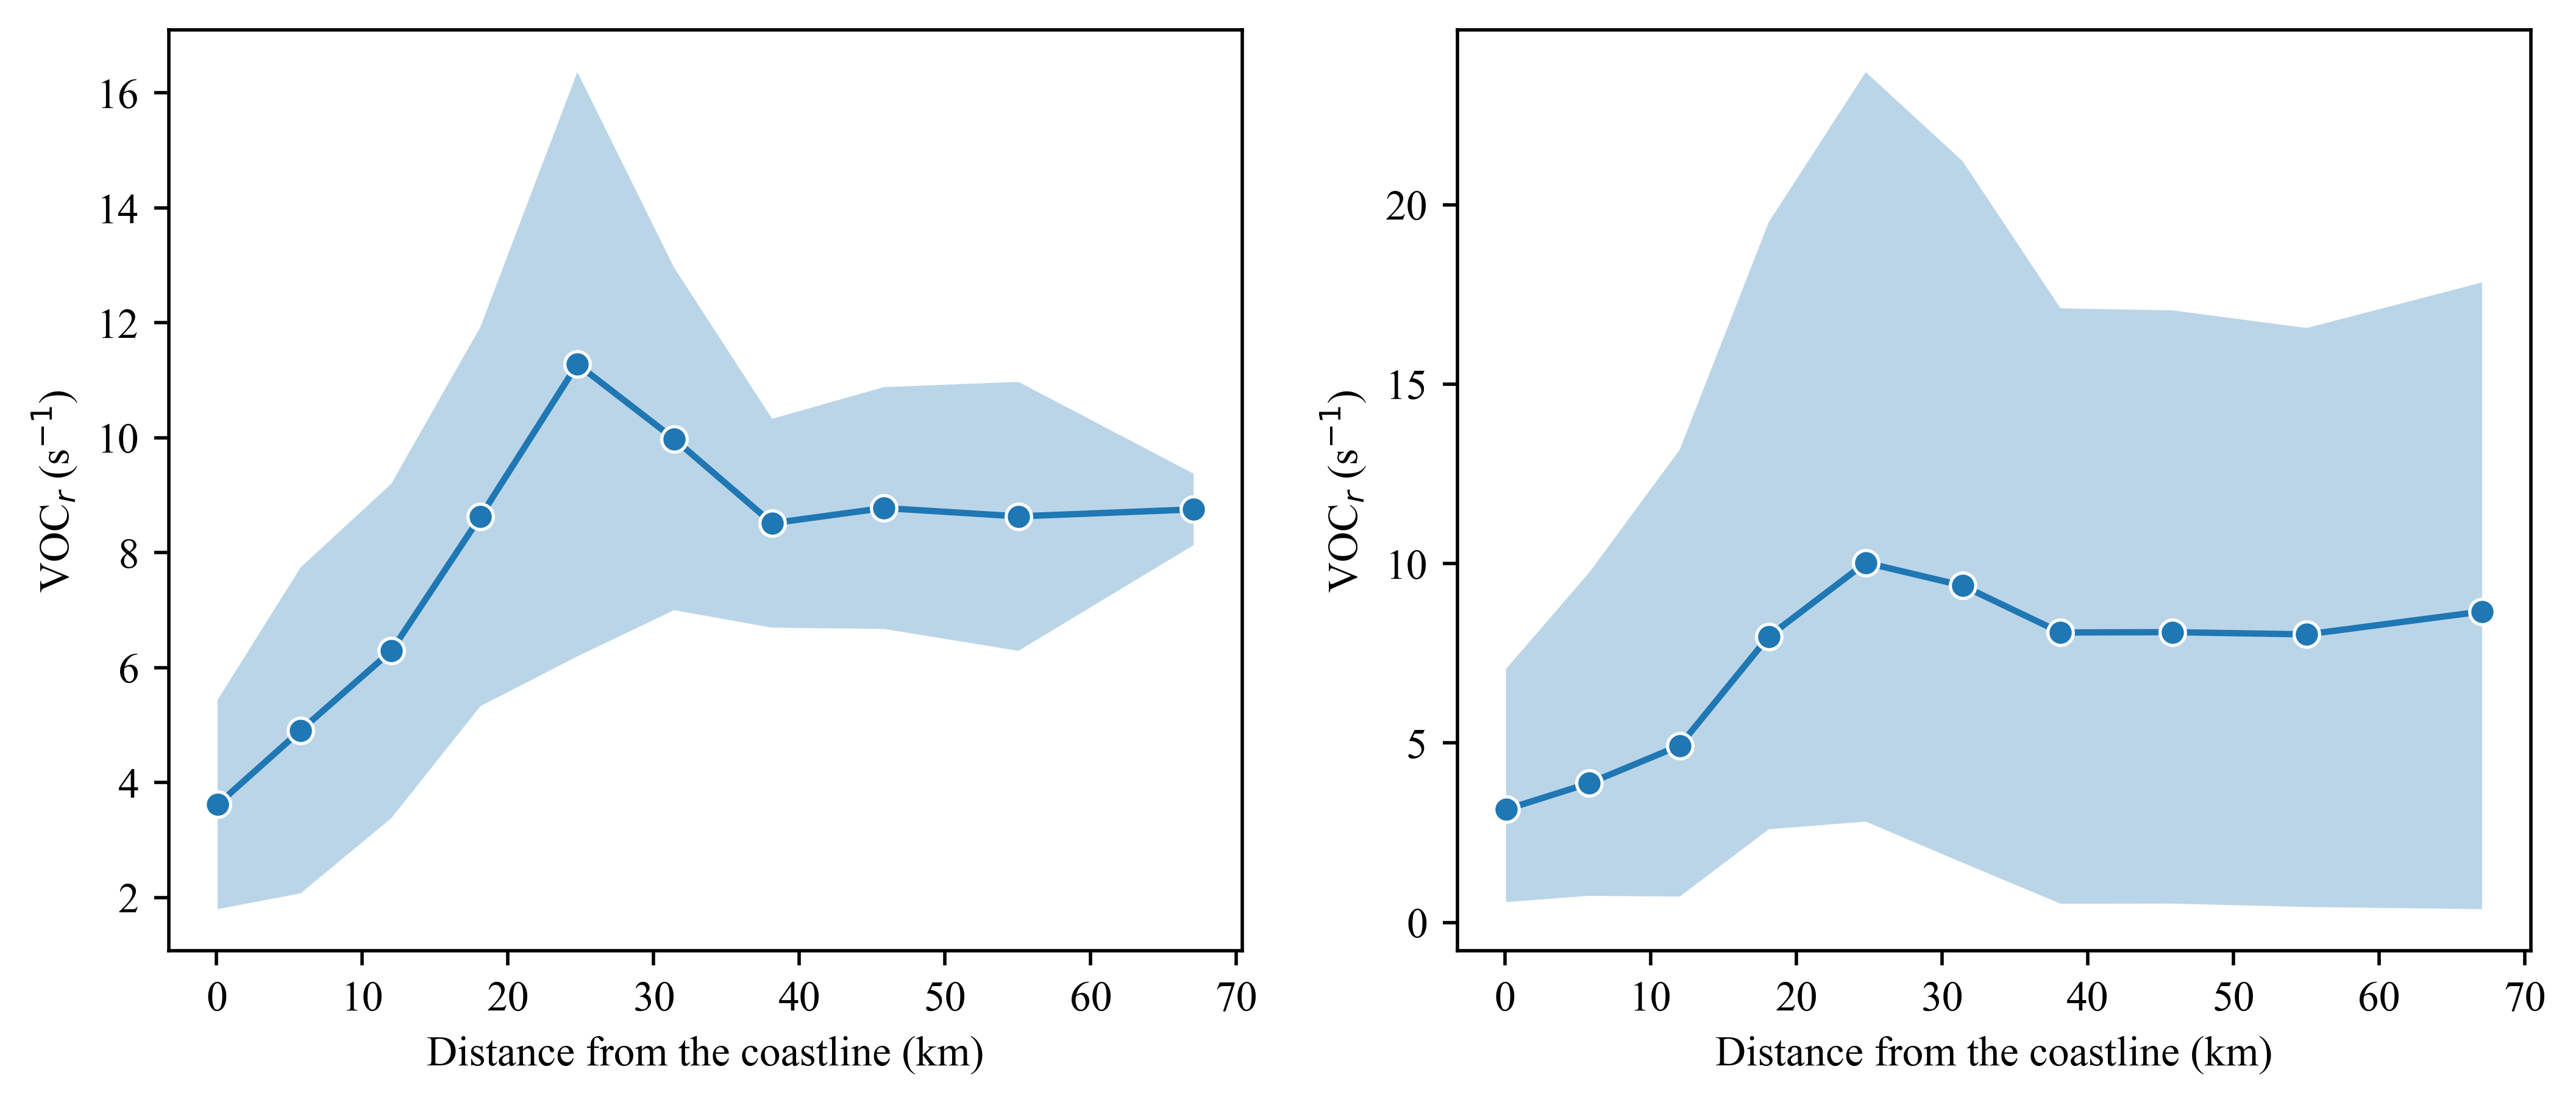

In [19]:
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=500)
#axs = axs.flatten()
colors=['tab:gray','tab:blue','tab:orange','tab:green','tab:purple']
i=0
for j in [0]:#[0,1,2,3]:

    df = gdfs[j]

    oh_bins, oh_bins_std, bins = calc_bins(df['vocr'].values, df['dist'].values)
    axs[i].fill_between(bins, oh_bins-oh_bins_std, oh_bins+oh_bins_std,alpha=0.3)
    sns.lineplot(x=bins,y=oh_bins,marker='o',ax=axs[i])
    axs[i].set_xlabel('Distance from the coastline (km)')
    axs[i].set_ylabel('VOC$_r$ (s$^{-1}$)')
    
i=1
for j in [0]:#[0,1,2,3]:

    df = gdfs[j]

    oh_bins, oh_bins_25d, oh_bins_75d, bins = calc_med_bins(df['vocr'].values, df['dist'].values)
    axs[i].fill_between(bins, oh_bins-oh_bins_25d, oh_bins+oh_bins_75d,alpha=0.3)
    sns.lineplot(x=bins,y=oh_bins,marker='o',ax=axs[i])
    axs[i].set_xlabel('Distance from the coastline (km)')
    axs[i].set_ylabel('VOC$_r$ (s$^{-1}$)')


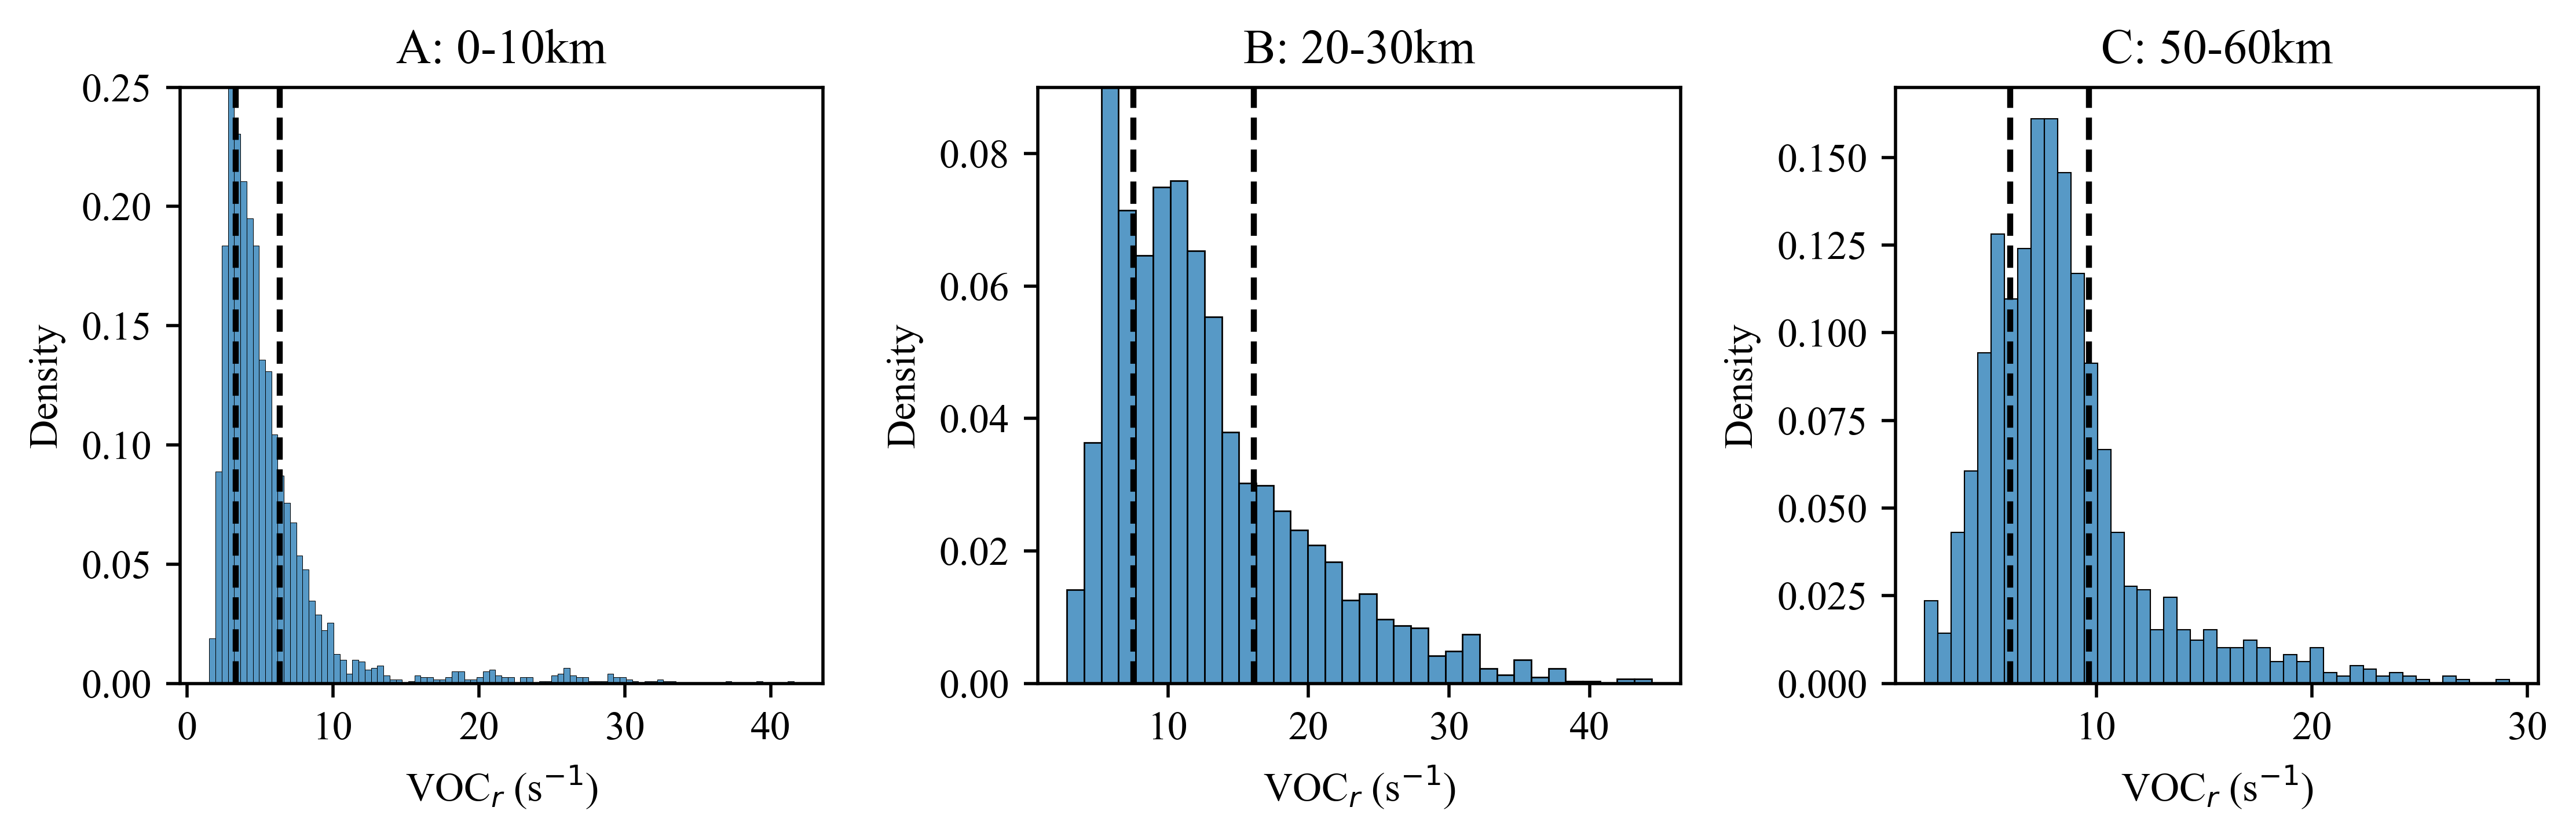

In [26]:
sels = [[4,6],[8,10],[12,14]]
dist_sels = [[0,10],[20,30],[50,60]]
ymaxs= [0.25, 0.09, 0.17]
labels = ['A: 0-10km','B: 20-30km','C: 50-60km']

fig, axs = plt.subplots(1,3,figsize=(9,3),dpi=500)

for i in range(3):
    j = 0
    cls_str = 'cls_indxs=={}'.format(i)
    indx =(gdfs[j]['dist']>dist_sels[i][0]) & (gdfs[j]['dist']<dist_sels[i][1])
    df = gdfs[j].loc[indx,:]
    #print(df['vocr'].quantile([0.1,0.2,0.25,0.5,0.75,0.8,0.9]))
    sns.histplot(x='vocr',data=df,ax=axs[i],stat='density') 
    d25 = np.nanquantile(df['vocr'],0.25)
    d75 = np.nanquantile(df['vocr'],0.75)
    
    axs[i].plot([d25,d25],[0,ymaxs[i]],linewidth=1.5,color='k',linestyle='--')
    axs[i].plot([d75,d75],[0,ymaxs[i]],linewidth=1.5,color='k',linestyle='--')
    axs[i].set_ylim([0,ymaxs[i]])
    axs[i].set_xlabel('VOC$_r$ (s$^{-1}$)')
    axs[i].set_title(labels[i],**{'fontname':'Times New Roman'})
plt.tight_layout()

In [11]:

data= pd.read_csv(datapath+'oh_po3_nox.csv')
data = data.query('vocr==5')

data['oh'] = data['oh']/data['oh'].mean()
data['nox'] = data['nox']/data['nox'].mean()

VOC$_r$:3.3-6.4s$^{-1}$
VOC$_r$:7.5-16.1s$^{-1}$
VOC$_r$:6.0-9.6s$^{-1}$


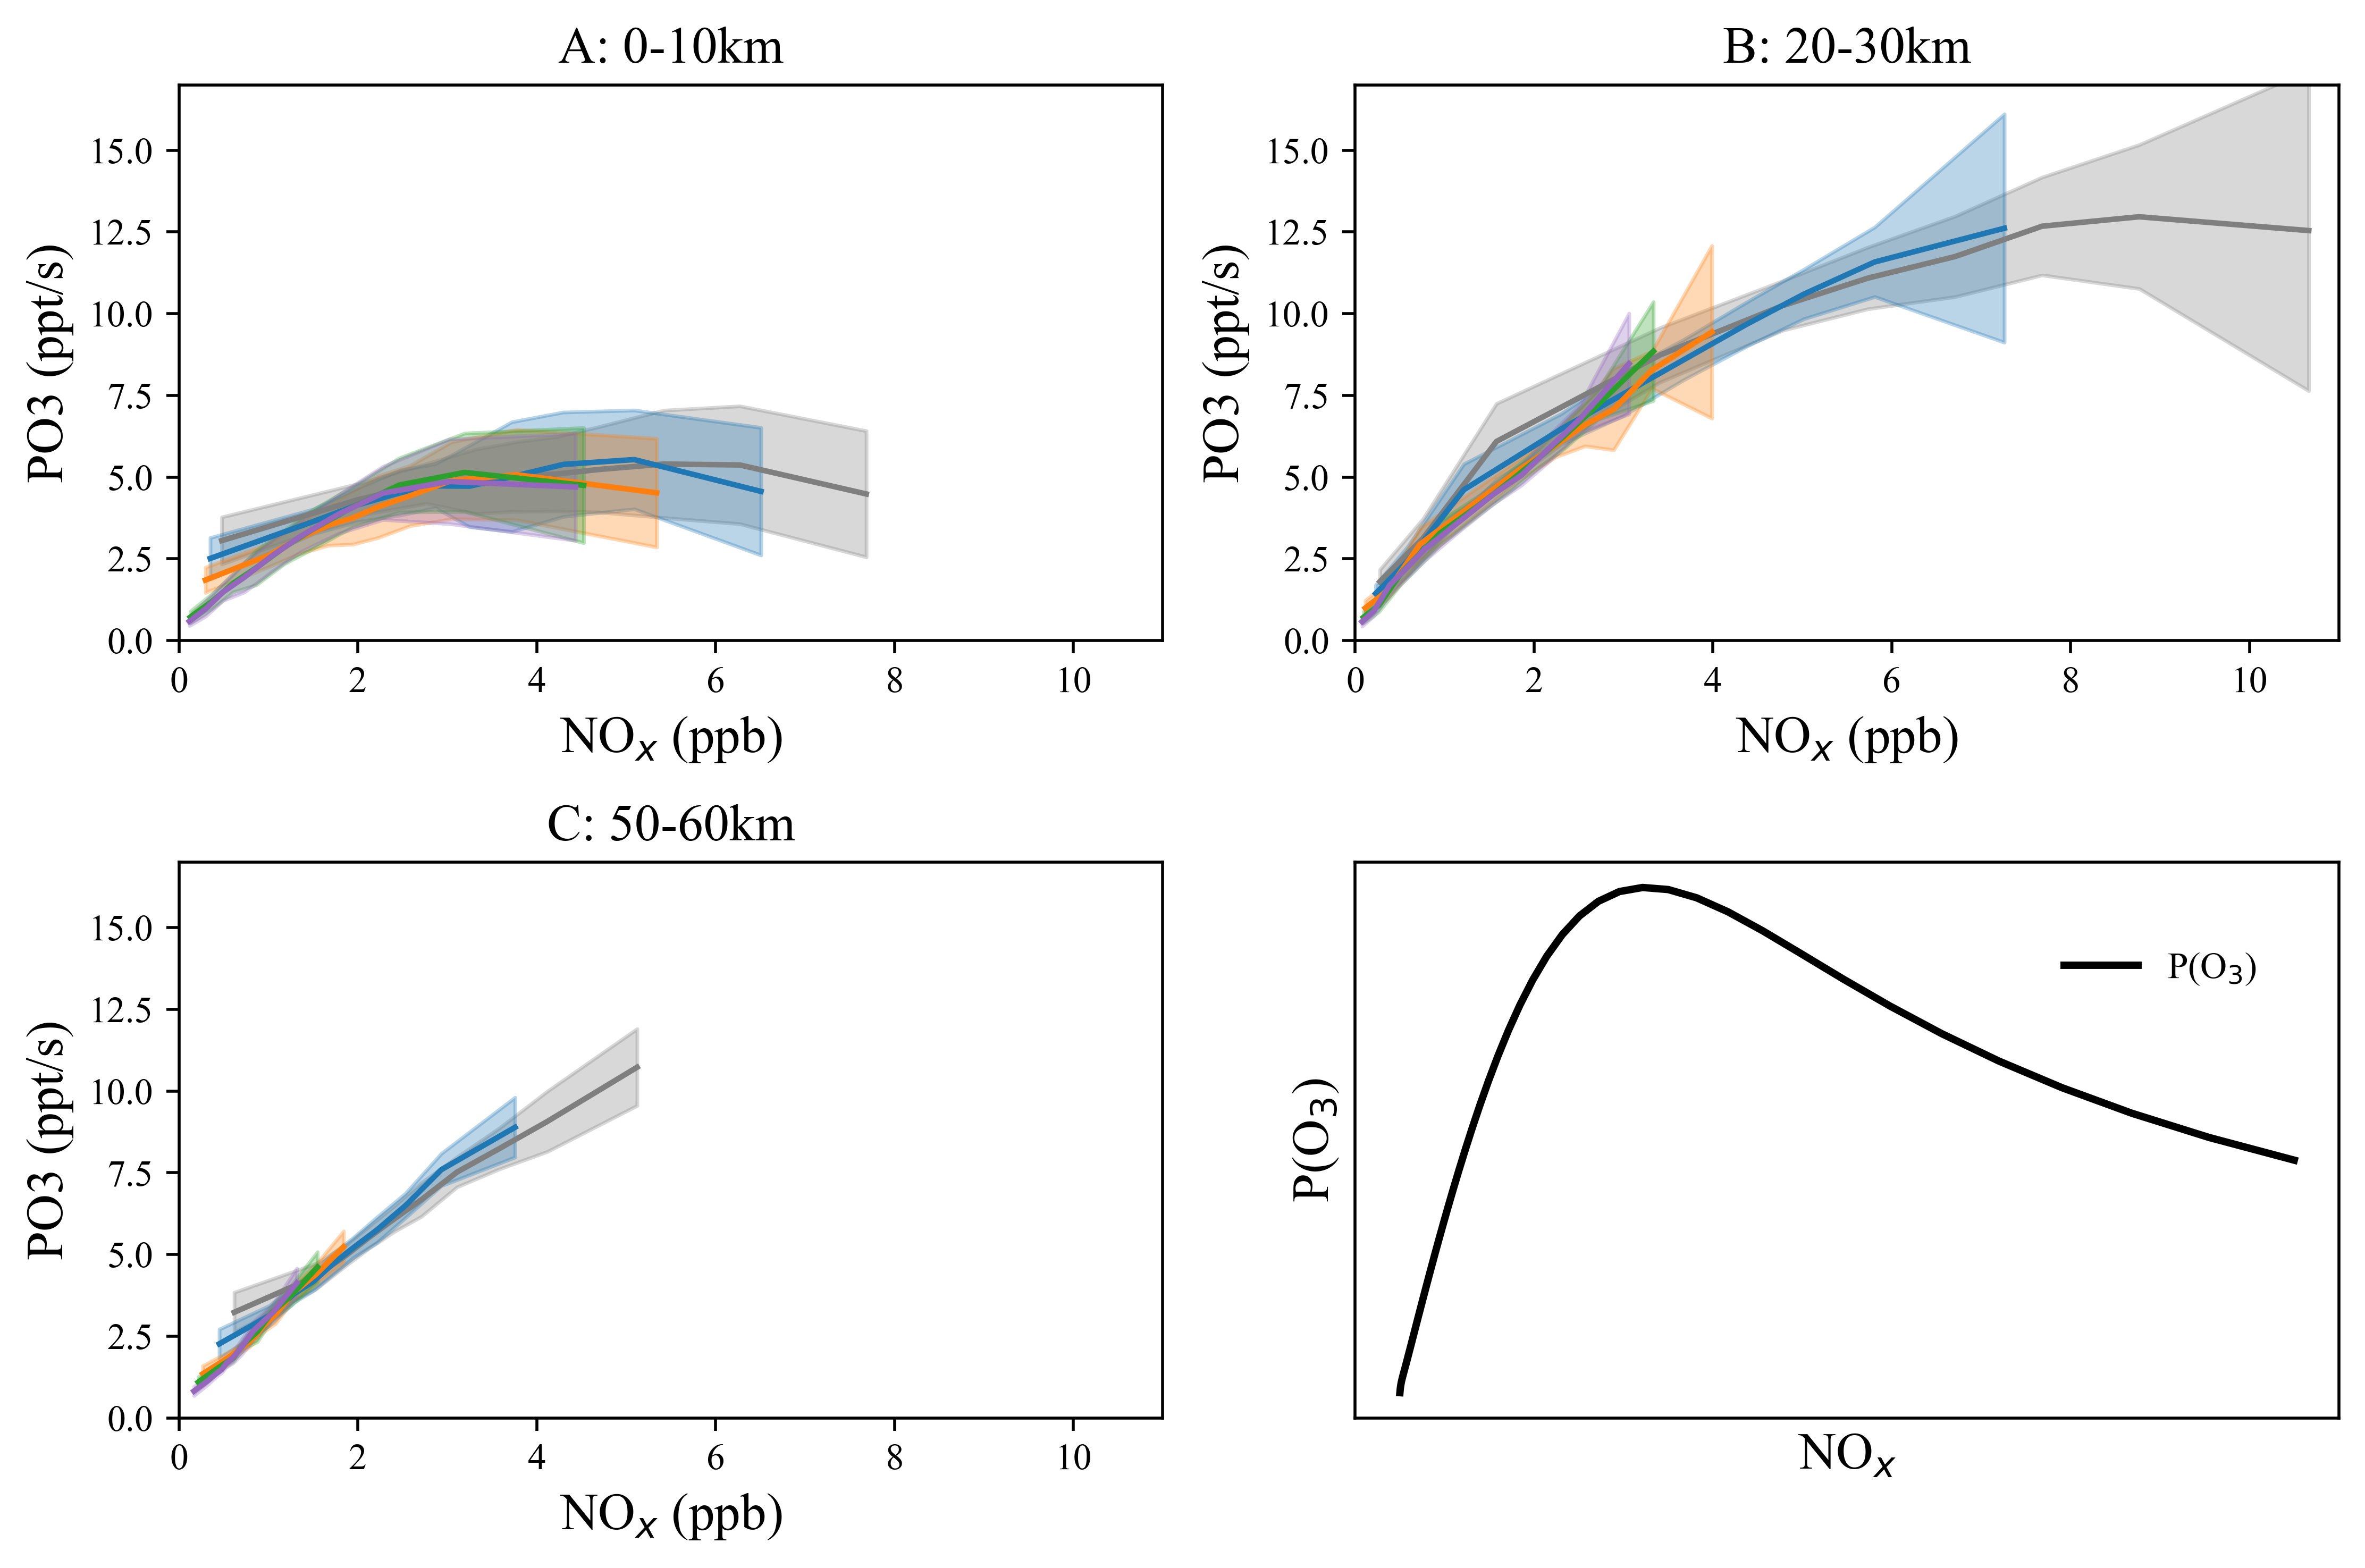

In [27]:
sels = [[3.3,4.5],[5.4,20],[6,8]]

dist_sels = [[0,10],[20,30],[50,60]]
ymaxs = [0.012,0.029,0.0195]
labels = ['A: 0-10km','B: 20-30km','C: 50-60km']
fig, axs = plt.subplots(2,2,figsize=(9,6),dpi=500)
axs = axs.flatten()
colors=['tab:gray','tab:blue','tab:orange','tab:green','tab:purple']

for i in range(3):
    for j in [0,1,2,3,4]:
        cls_str = 'cls_indxs=={}'.format(i)
        indx =  (gdfs[j]['dist']>dist_sels[i][0]) & (gdfs[j]['dist']<dist_sels[i][1])
        df = gdfs[j].loc[indx,:]
        if j == 0:
            d25 = np.nanquantile(df['vocr'],0.25)
            d75 = np.nanquantile(df['vocr'],0.75)
    
        indx = (df['vocr'] >= d25) & (df['vocr'] < d75)
        this_df = df[indx]
        
        oh_bins, oh_bins_std, bins = calc_bins(this_df['po3'].values, this_df['nox'].values)
        axs[i].fill_between(bins, oh_bins-oh_bins_std, oh_bins+oh_bins_std,alpha=0.3,color=colors[j])
        
        sns.lineplot(x=bins,y=oh_bins,ax=axs[i],color=colors[j],linewidth=1.5)
    print('VOC$_r$:{}-{}'.format(np.round(d25,1),np.round(d75,1))+'s$^{-1}$')
    #axs[i].text(0,ymaxs[i],'VOC$_r$:{}-{}'.format(np.round(d25,1),np.round(d75,1))+'s$^{-1}$',**{'fontname':'Times New Roman'})
    axs[i].set_title(labels[i],**{'fontname':'Times New Roman'},fontsize=14)
    axs[i].set_ylabel('PO3 (ppt/s)',**{'fontname':'Times New Roman'},fontsize=14)
    axs[i].set_xlabel('NO$_x$ (ppb)',**{'fontname':'Times New Roman'},fontsize=14)
    axs[i].set_ylim([0,17])
    axs[i].set_xlim([0,11])

    
i=3
sns.lineplot(x='nox',y='po3',data=data,ax=axs[i],color='k',linewidth = 2,label='P(O$_3$)')
plt.legend(bbox_to_anchor = (0.99, 1),fontsize=10,frameon=False)
plt.rcParams["font.family"] = "Times New Roman"

plt.legend(bbox_to_anchor = (0.95, .9),fontsize=10,frameon=False)
plt.rcParams["font.family"] = "Times New Roman"
axs[i].set_xticks([])
axs[i].set_yticks([])

axs[i].set_ylabel('P(O$_3$)',**{'fontname':'Times New Roman'},fontsize=14)
axs[i].set_xlabel('NO$_x$',**{'fontname':'Times New Roman'},fontsize=14)

plt.tight_layout()